In [24]:

GLM_name='Poisson'  # or your model

p = 10   # Number of features

maintain=1
folder='resultspart1'

index0 = 0.9

In [25]:
import pandas as pd
import  numpy as np
import torch
n = 700  # Main sample size
r = int(n**index0)  # Size of each sub-sample



def sigmoid(x):
    return 1/(1+np.exp(-x))


def f_1(x):
    return x[:, 0] + 0.25 * x[:, 1] ** 2+0.1*torch.tanh(0.5*x[:,2]-0.3)



hatsigma_700=list()
empsigma_700=list()
hatsigmao_700=list()
coverprob_700=list()
MAE_700=list()
for B in np.arange(400,1600,200):
    

    df_bf1 = pd.read_csv(f"{folder}/{GLM_name}fBf1n{n}p{p}B{B}r{r}.csv", header=None)
    df_sd  = pd.read_csv(f"{folder}/{GLM_name}sdf1nn{n}p{p}B{B}r{r}.csv", header=None)
    df_sdcrt  = pd.read_csv(f"{folder}/{GLM_name}sdcrtf1nn{n}p{p}B{B}r{r}.csv", header=None)
    xtest = torch.load(f"{folder}/xtest{p}.pt")

    tensor_bf1 = torch.tensor(df_bf1.values, dtype=torch.float32)
    tensor_sd  = torch.tensor(df_sd.values,  dtype=torch.float32)
    tensor_sdcrt  = torch.tensor(df_sdcrt.values,  dtype=torch.float32)

    truef = torch.tensor(f_1(xtest), dtype=torch.float32)

    if GLM_name=="Bernoulli":
        def activate(x):
            return 1/(1+np.exp(-x))
        
        true_f=truef.numpy()

        estimated_f = tensor_bf1.numpy()
        estimated_f0=estimated_f.mean(axis=0)
        quantile=np.quantile(np.abs(estimated_f0-true_f),maintain)
        index=(np.abs(estimated_f0-true_f)<=quantile)
        estimated_f = estimated_f[:,index]
        estimated_f0=estimated_f.mean(axis=0)
        std=tensor_sd.numpy()[:,index]
        stdcrt=tensor_sdcrt.numpy()[:,index]
        stdcrt = np.nan_to_num(stdcrt, nan=0.0)
        std0=np.std(estimated_f,axis=0)
        std1=np.mean(stdcrt,axis=0)
        true_f=true_f[index]
    
        cover=((true_f >= estimated_f-1.96*stdcrt) & (true_f <= estimated_f+1.96*stdcrt))
        cover0=((estimated_f0 >= estimated_f-1.96*stdcrt) & (estimated_f0 <= estimated_f+1.96*stdcrt))
        cover1=((true_f >= estimated_f-1.96*std1) & (true_f <= estimated_f+1.96*std1))
        AIL=np.mean(activate(estimated_f+1.96*stdcrt)-activate(estimated_f-1.96*stdcrt))
        AILsd=np.std(activate(estimated_f+1.96*stdcrt)-activate(estimated_f-1.96*stdcrt))
    
    # within_confidence_interval = ((true_f >= estimated_f-1.96*std) & (true_f <= estimated_f+1.96*std))
    elif GLM_name=="Poisson":
        def activate(x):
            return np.exp(x)
        true_f=np.log(np.log(1+np.exp(truef.numpy())))
        estimated_f = tensor_bf1.numpy()
        col_mean = np.nanmean(estimated_f, axis=0)              # 每列的均值
        inds = np.where(np.isnan(estimated_f))                  # 找出所有 NaN 的位置
        estimated_f[inds] = np.take(col_mean, inds[1]) 
        estimated_f0=estimated_f.mean(axis=0)
        estimated_f0=estimated_f.mean(axis=0)
        

        quantile=np.quantile(np.abs(estimated_f0-true_f),maintain)
        index=(np.abs(estimated_f0-true_f)<=quantile)

        estimated_f = estimated_f[:,index]
        estimated_f0=estimated_f.mean(axis=0)
        std=tensor_sd.numpy()[:,index]
        stdcrt=tensor_sdcrt.numpy()[:,index]
        col_mean = np.nanmean(stdcrt, axis=0)              # 每列的均值
        inds = np.where(np.isnan(stdcrt))                  # 找出所有 NaN 的位置
        stdcrt[inds] = np.take(col_mean, inds[1]) 
        std0=np.std(estimated_f,axis=0)
        std1=np.mean(std,axis=0)
        col_mean = np.nanmean(std, axis=0)              # 每列的均值
        inds = np.where(np.isnan(std))                  # 找出所有 NaN 的位置
        std[inds] = np.take(col_mean, inds[1]) 

        true_f=true_f[index]
        cover=((true_f >= estimated_f-1.96*stdcrt) & (true_f <= estimated_f+1.96*stdcrt))
        cover0=((estimated_f0 >= estimated_f-1.96*stdcrt) & (estimated_f0 <= estimated_f+1.96*stdcrt))
        AIL=np.mean(activate(estimated_f+1.96*stdcrt)-activate(estimated_f-1.96*stdcrt))
        AILsd=np.std(activate(estimated_f+1.96*stdcrt)-activate(estimated_f-1.96*stdcrt))
        

    else: 
        def activate(x):
            return 1/(1+np.exp(-x))
        true_f=truef.numpy()

        estimated_f = tensor_bf1.numpy()
        estimated_f0=estimated_f.mean(axis=0)
        
        quantile=np.quantile(np.abs(estimated_f0-true_f),maintain)
        index=(np.abs(estimated_f0-true_f)<=quantile)
        estimated_f = estimated_f[:,index]
        estimated_f0=estimated_f.mean(axis=0)
        std=tensor_sd.numpy()[:,index]
        stdcrt=tensor_sdcrt.numpy()[:,index]
        std0=np.std(estimated_f,axis=0)
        std1=np.mean(stdcrt,axis=0)
        true_f=true_f[index]
    
        cover=((true_f >= estimated_f-1.96*stdcrt) & (true_f <= estimated_f+1.96*stdcrt))
        cover0=((estimated_f0 >= estimated_f-1.96*stdcrt) & (estimated_f0 <= estimated_f+1.96*stdcrt))
        cover1=((true_f >= estimated_f-1.96*std1) & (true_f <= estimated_f+1.96*std1))
        AIL=np.mean(activate(estimated_f+1.96*stdcrt)-activate(estimated_f-1.96*stdcrt))
        AILsd=np.std(activate(estimated_f+1.96*stdcrt)-activate(estimated_f-1.96*stdcrt))

    empsigma_700.append(np.mean(std0))
    hatsigmao_700.append(np.mean(std))
    hatsigma_700.append(np.mean(stdcrt))
    coverprob_700.append(np.mean(np.mean(cover,axis=0)))
    MAE_700.append(np.mean(np.abs(estimated_f-true_f)))
    
    # print('The empirical std:',)
    # print('SE:',np.mean(std))
    # print('SE_c:',)
    # print("coverprob",)
    # print("coverprob_unbias",np.mean(np.mean(cover0,axis=0)))
    # print("AIL:",AIL)
    # print("AILsd:",AILsd)



/tmp/ipykernel_1651103/2354445069.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  truef = torch.tensor(f_1(xtest), dtype=torch.float32)
/tmp/ipykernel_1651103/2354445069.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  truef = torch.tensor(f_1(xtest), dtype=torch.float32)
/tmp/ipykernel_1651103/2354445069.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  truef = torch.tensor(f_1(xtest), dtype=torch.float32)
/tmp/ipykernel_1651103/2354445069.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTen

In [26]:
import pandas as pd
import  numpy as np
import torch
n=400
r = int(n**index0)  # Size of each sub-sample

def sigmoid(x):
    return 1/(1+np.exp(-x))


def f_1(x):
    return x[:, 0] + 0.25 * x[:, 1] ** 2+0.1*torch.tanh(0.5*x[:,2]-0.3)



hatsigma_400=list()
empsigma_400=list()
hatsigmao_400=list()
coverprob_400=list()
MAE_400 = list()
for B in np.arange(400,1600,200):

    df_bf1 = pd.read_csv(f"{folder}/{GLM_name}fBf1n{n}p{p}B{B}r{r}.csv", header=None)
    df_sd  = pd.read_csv(f"{folder}/{GLM_name}sdf1nn{n}p{p}B{B}r{r}.csv", header=None)
    df_sdcrt  = pd.read_csv(f"{folder}/{GLM_name}sdcrtf1nn{n}p{p}B{B}r{r}.csv", header=None)
    xtest = torch.load(f"{folder}/xtest{p}.pt")
    # 2) Convert to NumPy arrays, then to torch.Tensor
    #    (you can specify dtype=torch.float32 if needed)
    tensor_bf1 = torch.tensor(df_bf1.values, dtype=torch.float32)
    tensor_sd  = torch.tensor(df_sd.values,  dtype=torch.float32)
    tensor_sdcrt  = torch.tensor(df_sdcrt.values,  dtype=torch.float32)

    truef = torch.tensor(f_1(xtest), dtype=torch.float32)

    if GLM_name=="Bernoulli":
        def activate(x):
            return 1/(1+np.exp(-x))
        
        true_f=truef.numpy()

        estimated_f = tensor_bf1.numpy()
        estimated_f0=estimated_f.mean(axis=0)
        quantile=np.quantile(np.abs(estimated_f0-true_f),maintain)
        index=(np.abs(estimated_f0-true_f)<=quantile)
        estimated_f = estimated_f[:,index]
        estimated_f0=estimated_f.mean(axis=0)
        std=tensor_sd.numpy()[:,index]
        stdcrt=tensor_sdcrt.numpy()[:,index]
        stdcrt = np.nan_to_num(stdcrt, nan=0.0)
        std0=np.std(estimated_f,axis=0)
        std1=np.mean(stdcrt,axis=0)
        true_f=true_f[index]
    
        cover=((true_f >= estimated_f-1.96*stdcrt) & (true_f <= estimated_f+1.96*stdcrt))
        cover0=((estimated_f0 >= estimated_f-1.96*stdcrt) & (estimated_f0 <= estimated_f+1.96*stdcrt))
        cover1=((true_f >= estimated_f-1.96*std1) & (true_f <= estimated_f+1.96*std1))
        AIL=np.mean(activate(estimated_f+1.96*stdcrt)-activate(estimated_f-1.96*stdcrt))
        AILsd=np.std(activate(estimated_f+1.96*stdcrt)-activate(estimated_f-1.96*stdcrt))
    
    # within_confidence_interval = ((true_f >= estimated_f-1.96*std) & (true_f <= estimated_f+1.96*std))
    elif GLM_name=="Poisson":
        def activate(x):
            return np.exp(x)
        true_f=np.log(np.log(1+np.exp(truef.numpy())))
        estimated_f = tensor_bf1.numpy()
        col_mean = np.nanmean(estimated_f, axis=0)              # 每列的均值
        inds = np.where(np.isnan(estimated_f))                  # 找出所有 NaN 的位置
        estimated_f[inds] = np.take(col_mean, inds[1]) 
        estimated_f0=estimated_f.mean(axis=0)
        estimated_f0=estimated_f.mean(axis=0)
        

        quantile=np.quantile(np.abs(estimated_f0-true_f),maintain)
        index=(np.abs(estimated_f0-true_f)<=quantile)

        estimated_f = estimated_f[:,index]
        estimated_f0=estimated_f.mean(axis=0)
        std=tensor_sd.numpy()[:,index]
        stdcrt=tensor_sdcrt.numpy()[:,index]
        col_mean = np.nanmean(stdcrt, axis=0)              # 每列的均值
        inds = np.where(np.isnan(stdcrt))                  # 找出所有 NaN 的位置
        stdcrt[inds] = np.take(col_mean, inds[1]) 
        std0=np.std(estimated_f,axis=0)
        std1=np.mean(std,axis=0)
        col_mean = np.nanmean(std, axis=0)              # 每列的均值
        inds = np.where(np.isnan(std))                  # 找出所有 NaN 的位置
        std[inds] = np.take(col_mean, inds[1]) 

        true_f=true_f[index]
        cover=((true_f >= estimated_f-1.96*stdcrt) & (true_f <= estimated_f+1.96*stdcrt))
        cover0=((estimated_f0 >= estimated_f-1.96*stdcrt) & (estimated_f0 <= estimated_f+1.96*stdcrt))
        AIL=np.mean(activate(estimated_f+1.96*stdcrt)-activate(estimated_f-1.96*stdcrt))
        AILsd=np.std(activate(estimated_f+1.96*stdcrt)-activate(estimated_f-1.96*stdcrt))
        

    else: 
        def activate(x):
            return 1/(1+np.exp(-x))
        true_f=truef.numpy()

        estimated_f = tensor_bf1.numpy()
        estimated_f0=estimated_f.mean(axis=0)
        
        quantile=np.quantile(np.abs(estimated_f0-true_f),maintain)
        index=(np.abs(estimated_f0-true_f)<=quantile)
        estimated_f = estimated_f[:,index]
        estimated_f0=estimated_f.mean(axis=0)
        std=tensor_sd.numpy()[:,index]
        stdcrt=tensor_sdcrt.numpy()[:,index]
        std0=np.std(estimated_f,axis=0)
        std1=np.mean(stdcrt,axis=0)
        true_f=true_f[index]
    
        cover=((true_f >= estimated_f-1.96*stdcrt) & (true_f <= estimated_f+1.96*stdcrt))
        cover0=((estimated_f0 >= estimated_f-1.96*stdcrt) & (estimated_f0 <= estimated_f+1.96*stdcrt))
        cover1=((true_f >= estimated_f-1.96*std1) & (true_f <= estimated_f+1.96*std1))
        AIL=np.mean(activate(estimated_f+1.96*stdcrt)-activate(estimated_f-1.96*stdcrt))
        AILsd=np.std(activate(estimated_f+1.96*stdcrt)-activate(estimated_f-1.96*stdcrt))

    empsigma_400.append(np.mean(std0))
    hatsigma_400.append(np.mean(stdcrt))
    hatsigmao_400.append(np.mean(std))
    coverprob_400.append(np.mean(np.mean(cover,axis=0)))
    MAE_400.append(np.mean(np.abs(estimated_f-true_f)))
    # print('The empirical std:',)
    # print('SE:',np.mean(std))
    # print('SE_c:',)
    # print("coverprob",)
    # print("coverprob_unbias",np.mean(np.mean(cover0,axis=0)))
    # print("AIL:",AIL)
    # print("AILsd:",AILsd)



/tmp/ipykernel_1651103/2613130600.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  truef = torch.tensor(f_1(xtest), dtype=torch.float32)
/tmp/ipykernel_1651103/2613130600.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  truef = torch.tensor(f_1(xtest), dtype=torch.float32)
/tmp/ipykernel_1651103/2613130600.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  truef = torch.tensor(f_1(xtest), dtype=torch.float32)
/tmp/ipykernel_1651103/2613130600.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTen

<>:42: SyntaxWarning: invalid escape sequence '\s'
<>:42: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1651103/2187027828.py:42: SyntaxWarning: invalid escape sequence '\s'
  plt.title(f'Empirical vs Theoretical $\sigma$ $(n=400,700)$',fontsize=18)


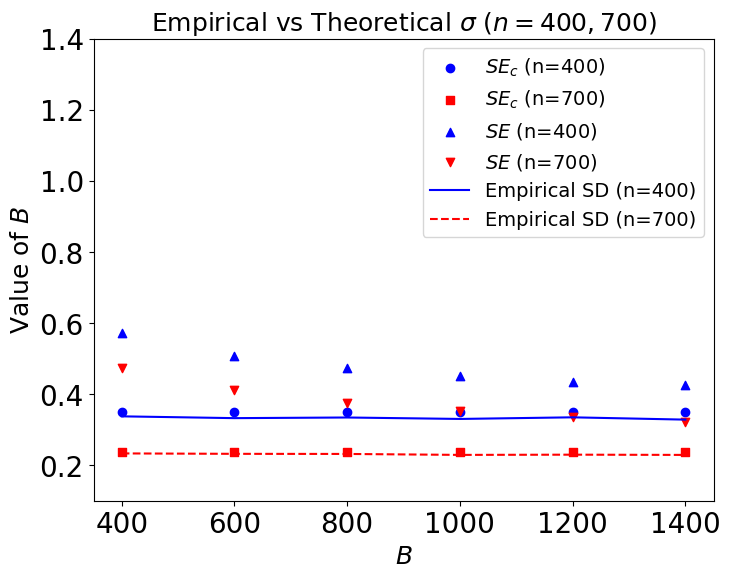

In [27]:

empsigma_400=np.array(empsigma_400)
hatsigma_400=np.array(hatsigma_400)
hatsigmao_400=np.array(hatsigmao_400)
coverprob_400=np.array(coverprob_400)
MAE_400=np.array(MAE_400)

empsigma_700=np.array(empsigma_700)
hatsigma_700=np.array(hatsigma_700)
hatsigmao_700=np.array(hatsigmao_700)
coverprob_700=np.array(coverprob_700)
MAE_700=np.array(MAE_700)
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

def plot_sigma(x, empsigma_400, hatsigma_400,hatsigmao_400, empsigma_700, hatsigma_700,hatsigmao_700,name):


    plt.figure(figsize=(8, 6))

    # Empirical points
    plt.scatter(x, hatsigma_400, color='blue', label=f'$SE_c$ (n=400)', marker='o',)
    plt.scatter(x, hatsigma_700, color='red', label=f'$SE_c$ (n=700)', marker='s')


    plt.scatter(x, hatsigmao_400, color='blue', label=f'$SE$ (n=400)', marker='^')
    plt.scatter(x, hatsigmao_700, color='red', label=f'$SE$ (n=700)', marker='v')

    # Theoretical lines
    plt.plot(x, empsigma_400, color='blue', linestyle='-', label='Empirical SD (n=400)')
    plt.plot(x, empsigma_700, color='red', linestyle='--', label='Empirical SD (n=700)')

    # plt.plot(x, hatsigma_400, color='blue', linestyle='-', label=f'$SE_c$ (n=400)')
    # plt.plot(x, hatsigma_700, color='red', linestyle='--', label=f'$SE_c$ (n=700)')


    # Labels and title
    plt.ylim(0.1,1.4)
    plt.xlabel(f'$B$',fontsize=18)
    plt.ylabel(f'Value of $B$',fontsize=18)
    plt.title(f'Empirical vs Theoretical $\sigma$ $(n=400,700)$',fontsize=18)
    plt.legend(fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=20)
    # plt.grid(True)
    # plt.show()
    plt.savefig(name, bbox_inches='tight') 



def plot_cp(x, cp_400, cp_700,name):
    plt.figure(figsize=(8, 6))

    # Plot curves
    plt.plot(x, cp_400, color='blue', marker='o', linestyle='-', label=f'$n=400$' )
    plt.plot(x, cp_700, color='red', marker='s', linestyle='--', label=f'$n=700$' )

    # Add reference line at 0.95 if needed
    plt.axhline(y=0.95, color='gray', linestyle=':', label='95% nominal')

    # Labels and title
    plt.ylim(0.7,1)
    plt.xlabel(f'$B$',fontsize=18)
    plt.ylabel(f'Coverage Probability',fontsize=18)
    plt.title(f'Coverage Probability vs $B$',fontsize=18)
    plt.legend(fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=20)
    # plt.grid(True)

    # Save with tight bounding box
    plt.savefig(name, bbox_inches='tight')
    plt.close()

def plot_MAE(x, MAE_400, MAE_700,name):
    plt.figure(figsize=(8, 6))

    # Plot curves
    plt.plot(x, MAE_400, color='blue', marker='o', linestyle='-', label=f'$n=400$')
    plt.plot(x, MAE_700, color='red', marker='s', linestyle='--', label=f'$n=700$')



    # Labels and title

    plt.xlabel(f'$B$',fontsize=18)
    plt.ylabel(f'MAE',fontsize=18)
    plt.title(f'MAE vs $B$',fontsize=18)
    plt.legend(fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=20)
    # plt.grid(True)

    # Save with tight bounding box
    plt.savefig(name, bbox_inches='tight')
    plt.close()

x = np.arange(400, 1600, 200)
plot_sigma(x, empsigma_400, hatsigma_400,hatsigmao_400, empsigma_700, hatsigma_700,hatsigmao_700,name=f'sensitiveB_{GLM_name}_sigma.pdf')
plot_cp(x, coverprob_400, coverprob_700, name=f"sensitiveB_{GLM_name}_cp.pdf")
plot_MAE(x, MAE_400, MAE_700, name=f"sensitiveB_{GLM_name}_MAE.pdf")